# 04.Modelado predictivo con ML

### Importacion de la data

In [8]:
import pandas as pd
import numpy as np
df_news=pd.read_csv("../Datos/noticias_bitcoin_sentimientos.csv")
df_btc=pd.read_csv("../Datos/BTC_USD_Media_Movil.csv")
df_btc['Date']=pd.to_datetime(df_btc['Date'])
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1096 non-null   datetime64[ns]
 1   Close      1096 non-null   float64       
 2   High       1096 non-null   float64       
 3   Low        1096 non-null   float64       
 4   Open       1096 non-null   float64       
 5   Volume     1096 non-null   float64       
 6   Close_7d   1090 non-null   float64       
 7   Volume_7d  1090 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 68.7 KB


In [9]:
df_news.head()

,fecha,titulo,descripcion,contenido,url,fuente,score
0,2025-04-07,Bitcoin price falls amid tariff market rout,"Bitcoin, the world's largest cryptocurrency by...","The price of bitcoin (BTC-USD), the world's la...",https://ca.finance.yahoo.com/news/bitcoin-pric...,Yahoo Canada Finance,-0.536233
1,2025-04-07,US crypto stocks plunge as bitcoin hits new 20...,U.S.-listed shares of crypto companies tumbled...,(Reuters) - U.S.-listed shares of crypto compa...,https://finance.yahoo.com/news/us-crypto-stock...,Yahoo Finance,-0.637867
2,2025-04-05,SpaceX tourists return to Earth after historic...,Bitcoin investor Chun Wang took three people o...,Four space tourists have safely arrived back o...,https://news.sky.com/story/spacex-tourists-ret...,Sky News,0.630636
3,2025-04-04,BlackRock buys $66M in Bitcoin amid market crash,BlackRock acquired $66 million in Bitcoin on t...,The sell-off in the stock market didn’t cool d...,https://finance.yahoo.com/news/blackrock-buys-...,Yahoo Finance,-0.137903
4,2025-04-04,Markets tumble as Trump launches ‘Unstoppable’...,Markets fell after Trump announced new tariffs...,"On April 3, markets worldwide dropped sharply ...",https://finance.yahoo.com/news/markets-tumble-...,Yahoo Finance,-0.489370


## Preprosesamiento de la data

In [10]:
df_news['fecha'] = pd.to_datetime(df_news['fecha'], format='%Y-%m-%d')

df_news_avg_score = df_news.groupby('fecha')['score'].mean().reset_index()

In [496]:
import plotly.express as px

fig = px.line(df_news_avg_score, x='fecha', y='score', title='Promedio del Score a lo Largo del Tiempo', markers=True)
fig.update_layout(xaxis_title='Fecha', yaxis_title='Avg Score', template='plotly_white')
fig.show()


## Implementacion del modelo

In [497]:
btc_index = df_btc.set_index(pd.to_datetime(df_btc['Date']))['Close'].dropna()
btc_index.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1096 entries, 2022-04-06 to 2025-04-05
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1096 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


Necesitamos analizar si sus propiedades estadisticas no cambian a lo largo del tiempo. Para ello es necesario aplicar Dickey-Fuller para llegar a una conclusion y actuar a partir de ahi.

### Analisis de Estacionariedad

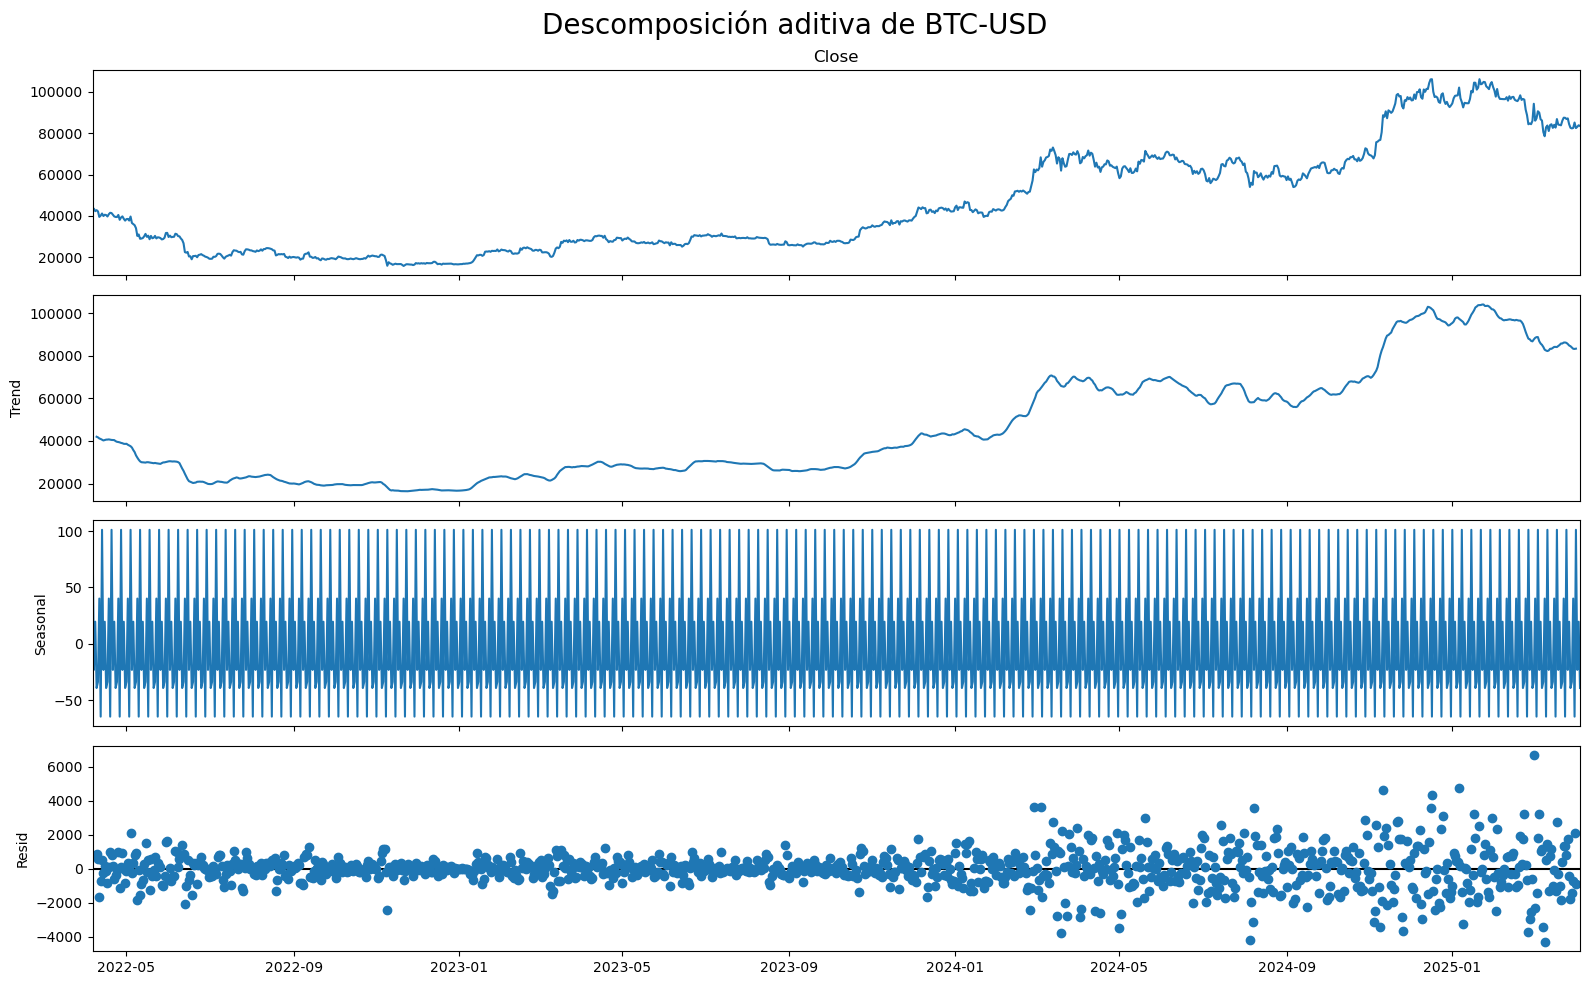

In [498]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Descomposición
result = seasonal_decompose(btc_index, model='additive', period=7)  # puedes ajustar el periodo si conoces una estacionalidad clara
fig = result.plot()
fig.set_size_inches(16, 10)
plt.suptitle('Descomposición aditiva de BTC-USD', fontsize=20)
plt.tight_layout()
plt.show()

### Prueba Dickey Fuller

#### Definimos la funcion para implementar la prueba

In [499]:
from statsmodels.tsa.stattools import adfuller

def prueba_adf(serie, nombre_serie='Serie'):
    """
    Aplica la prueba ADF a una serie temporal y muestra el resultado con interpretación.

    Parámetros:
    - serie: Serie temporal (pandas Series)
    - nombre_serie: Nombre descriptivo de la serie para el encabezado del resultado
    """
    resultado_adf = adfuller(serie.dropna())

    print(f'\n--- Prueba ADF (Augmented Dickey-Fuller) para {nombre_serie} ---')
    print(f'Estadístico ADF: {resultado_adf[0]}')
    print(f'Valor p: {resultado_adf[1]}')
    print('Valores críticos:')
    for key, value in resultado_adf[4].items():
        print(f'   {key}: {value}')

    if resultado_adf[1] <= 0.05:
        print(f"\n✅ {nombre_serie} es estacionaria (rechazamos H0).")
    else:
        print(f"\n❌ {nombre_serie} NO es estacionaria (no se rechaza H0).")


#### Con la serie Original

In [500]:
prueba_adf(df_btc['Close'], 'Precio de cierre del Bitcoin Original')



--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin Original ---
Estadístico ADF: -0.41277959626419064
Valor p: 0.9079430766815466
Valores críticos:
   1%: -3.4364081161854747
   5%: -2.8642149051061954
   10%: -2.5681942108302214

❌ Precio de cierre del Bitcoin Original NO es estacionaria (no se rechaza H0).


####  Con la serie diferenciada

In [501]:
valor_inicial = df_btc['Close'].iloc[0]
serie_diff = df_btc['Close'].diff().dropna()
prueba_adf(serie_diff, 'Precio de cierre del Bitcoin Diferenciado')



--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin Diferenciado ---
Estadístico ADF: -7.9996339957446745
Valor p: 2.352876572073833e-12
Valores críticos:
   1%: -3.4364081161854747
   5%: -2.8642149051061954
   10%: -2.5681942108302214

✅ Precio de cierre del Bitcoin Diferenciado es estacionaria (rechazamos H0).


In [502]:
serie_diff_2 = serie_diff.diff().dropna()
prueba_adf(serie_diff_2, 'Precio de cierre del Bitcoin Diferenciado 2 veces')


--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin Diferenciado 2 veces ---
Estadístico ADF: -11.730080904086758
Valor p: 1.3482235824499878e-21
Valores críticos:
   1%: -3.436470487817901
   5%: -2.8642424166404
   10%: -2.5682088634756735

✅ Precio de cierre del Bitcoin Diferenciado 2 veces es estacionaria (rechazamos H0).


In [503]:
serie_diff_3 = serie_diff_2.diff().dropna()
prueba_adf(serie_diff_3, 'Precio de cierre del Bitcoin Diferenciado 3 veces')


--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin Diferenciado 3 veces ---
Estadístico ADF: -15.773715164654096
Valor p: 1.152854506377434e-28
Valores críticos:
   1%: -3.4364647646486093
   5%: -2.864239892228526
   10%: -2.5682075189699822

✅ Precio de cierre del Bitcoin Diferenciado 3 veces es estacionaria (rechazamos H0).


Vemos que paso la prueba y no tiene fuertes tendencias, ni varianza cambiante por lo que lo revisamos a continuacion:

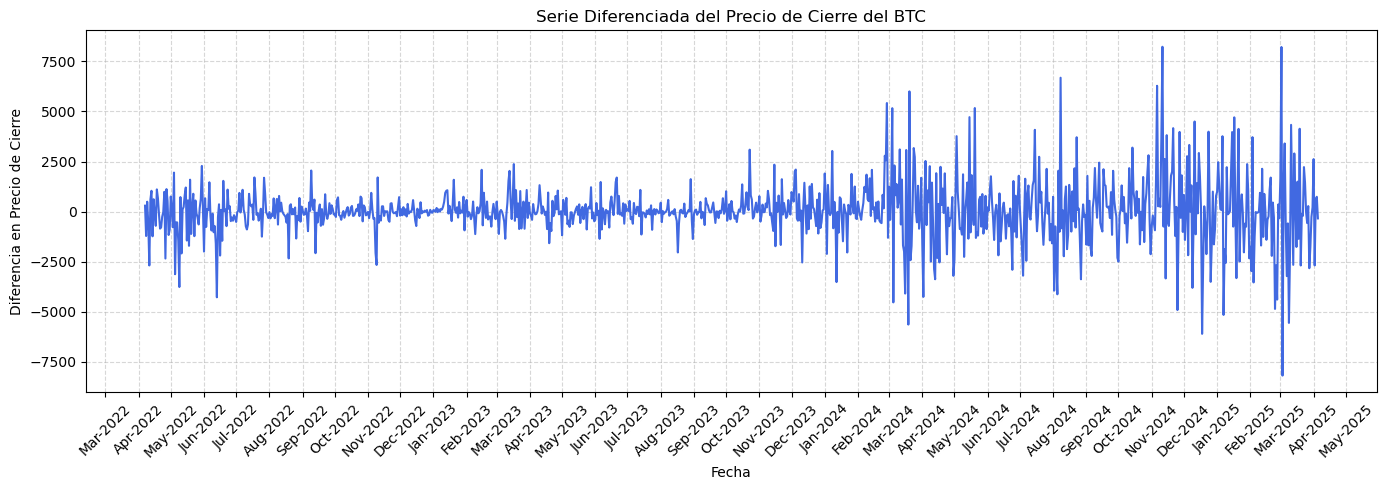

In [504]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Asegúrate de que las fechas sean tipo datetime
df_btc['Date'] = pd.to_datetime(df_btc['Date'])

# Crear la figura
plt.figure(figsize=(14, 5))
plt.plot(df_btc['Date'][2:], serie_diff.values, color='royalblue')

# Títulos y etiquetas
plt.title('Serie Diferenciada del Precio de Cierre del BTC')
plt.xlabel('Fecha')
plt.ylabel('Diferencia en Precio de Cierre')

# Configurar el eje X para mostrar ticks mensuales
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  

# Mejoras visuales
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Vemos que los valores de la serie diferenciada giran entorno al eje horizontal y no se observan tendencias marcadas. Vemos que a partir de cierta fecha los valores empiezan a ser mas cambiantes a lo largo del tiempo

In [505]:
# Aplicar logaritmo a la serie original
serie_log = np.log(df_btc['Close']).dropna()
prueba_adf(serie_log, 'Precio de cierre del Bitcoin Logarítmico')


--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin Logarítmico ---
Estadístico ADF: -0.2873761345220865
Valor p: 0.9272733176268361
Valores críticos:
   1%: -3.4363470029475525
   5%: -2.864187948086107
   10%: -2.568179853605536

❌ Precio de cierre del Bitcoin Logarítmico NO es estacionaria (no se rechaza H0).


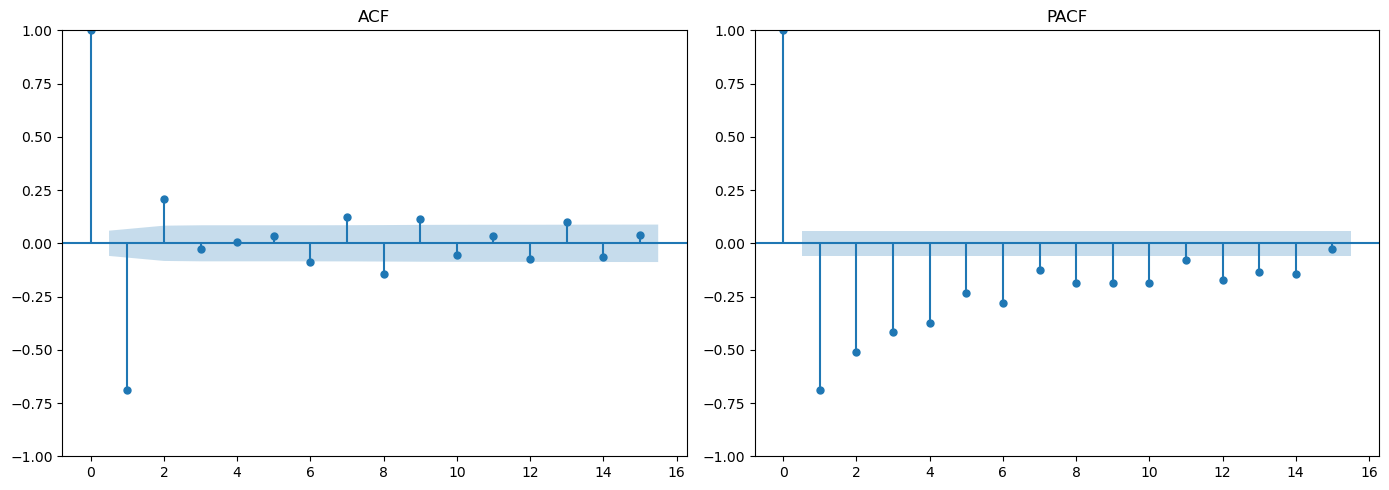

In [506]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plot_acf(serie_diff_3, lags=15, ax=plt.gca())
plt.title("ACF")

plt.subplot(1,2,2)
plot_pacf(serie_diff_3, lags=15, ax=plt.gca(), method='ywm')
plt.title("PACF")

plt.tight_layout()
plt.show()


Al ver el analisis de autocorrelacion solo muestra un pico fuerte en p=1 y q=1 por lo que seleccionaremos estos parametros.

## Arima

In [507]:
from statsmodels.tsa.arima.model import ARIMA

# Entrenar el modelo ARIMA con (p=1, d=0, q=1) como ejemplo, ya que la serie ya está diferenciada
modelo = ARIMA(df_btc['Close'], order=(11, 3, 13))  # d=0 porque ya está diferenciada
modelo_entrenado = modelo.fit()



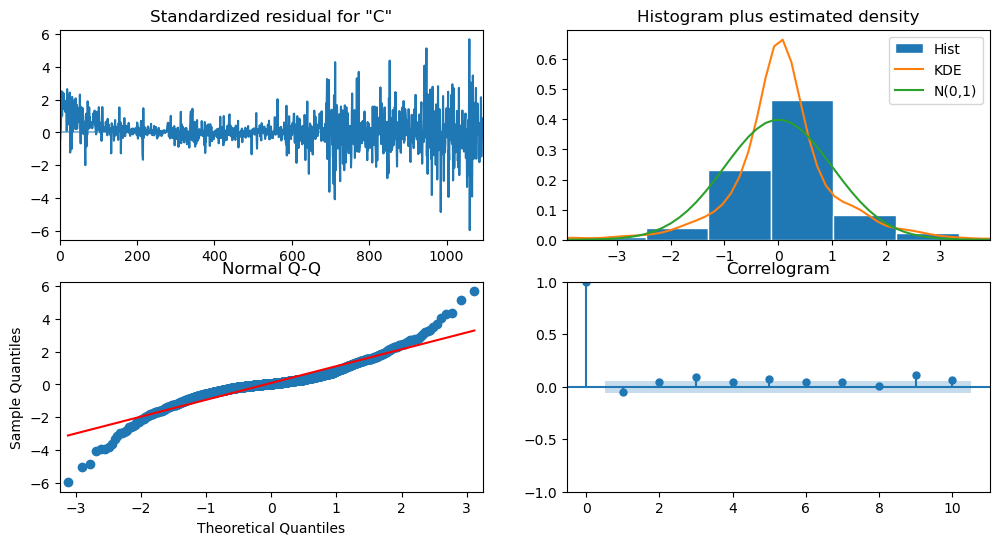

In [508]:
modelo_entrenado.plot_diagnostics(figsize=(12, 6))
plt.show()


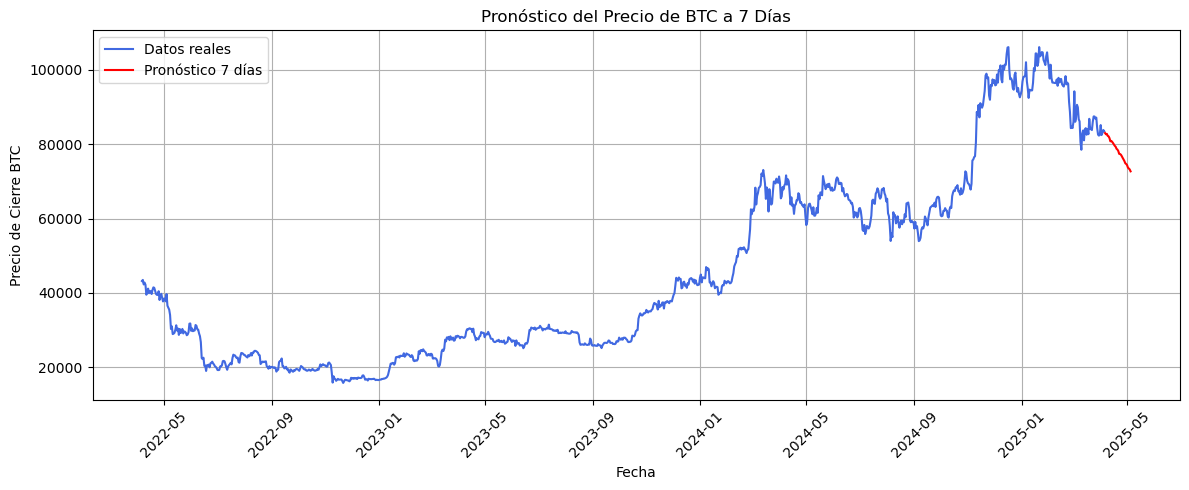

In [509]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Predicción a 7 días
forecast = pd.DataFrame(modelo_entrenado.forecast(steps=30))

# Índice de fechas futuras a partir de la última fecha
fecha_inicio = df_btc['Date'].iloc[-1] + pd.Timedelta(days=1)
forecast_index = pd.date_range(start=fecha_inicio, periods=30, freq='D')
forecast.index = forecast_index

# Visualización
plt.figure(figsize=(12, 5))
plt.plot(df_btc['Date'], df_btc['Close'], label='Datos reales', color='royalblue')
plt.plot(forecast.index, forecast.values, label='Pronóstico 7 días', color='red')
plt.title('Pronóstico del Precio de BTC a 7 Días')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre BTC')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.show()

In [510]:
forecast

,predicted_mean
2025-04-06,83021.647666
2025-04-07,82696.677945
2025-04-08,82803.831841
2025-04-09,82265.090170
2025-04-10,82137.935915
2025-04-11,81663.143557
2025-04-12,80790.398588
2025-04-13,80918.964159
2025-04-14,80674.320167
2025-04-15,80346.530009


In [511]:
#Prueba dickey-fuller para la serie con media movil
prueba_adf(df_btc['Close_7d'], 'Precio de cierre del Bitcoin con media movil')


--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin con media movil ---
Estadístico ADF: -0.6434214751127477
Valor p: 0.8608656736411056
Valores críticos:
   1%: -3.4364934880312177
   5%: -2.8642525616723336
   10%: -2.568214266743025

❌ Precio de cierre del Bitcoin con media movil NO es estacionaria (no se rechaza H0).


In [512]:
serie_media_movil_diff = df_btc['Close_7d'].diff().dropna()
prueba_adf(serie_media_movil_diff, 'Precio de cierre del Bitcoin con media movil Diferenciado')


--- Prueba ADF (Augmented Dickey-Fuller) para Precio de cierre del Bitcoin con media movil Diferenciado ---
Estadístico ADF: -4.923220061742093
Valor p: 3.1420974563487515e-05
Valores críticos:
   1%: -3.4364934880312177
   5%: -2.8642525616723336
   10%: -2.568214266743025

✅ Precio de cierre del Bitcoin con media movil Diferenciado es estacionaria (rechazamos H0).


Text(0.5, 1.0, 'Serie con Media Móvil del Precio de Cierre del BTC')

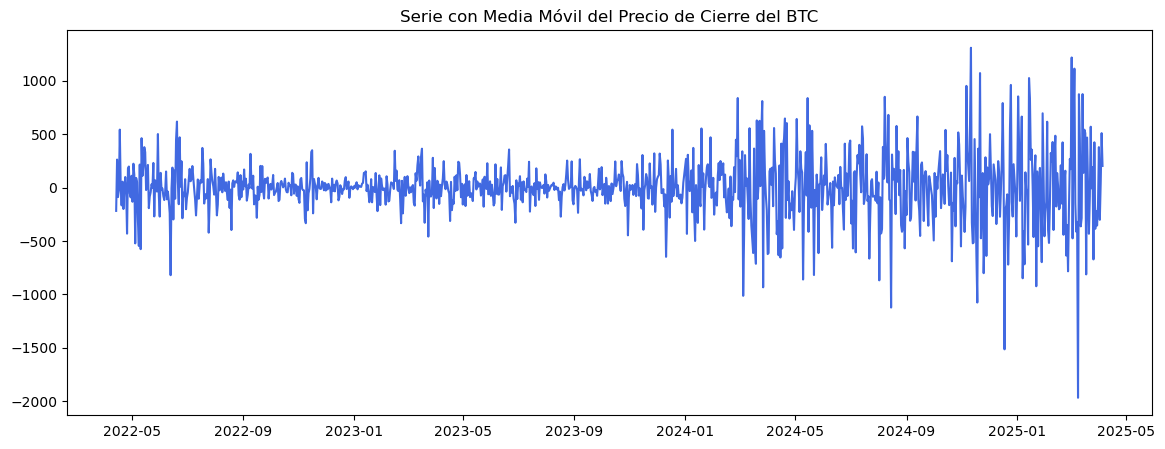

In [513]:
# Graficar la  serie con media móvil
plt.figure(figsize=(14, 5))
plt.plot(df_btc['Date'][8:], serie_media_movil_diff.diff(), color='royalblue')
plt.title('Serie con Media Móvil del Precio de Cierre del BTC')

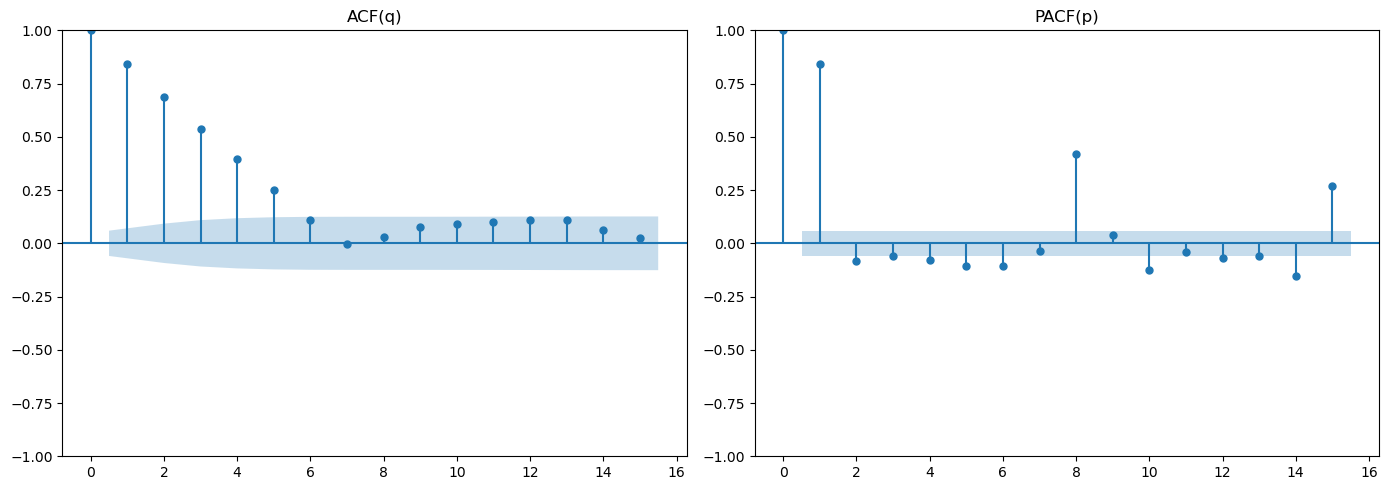

In [514]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plot_acf(serie_media_movil_diff, lags=15, ax=plt.gca())
plt.title("ACF(q)")

plt.subplot(1,2,2)
plot_pacf(serie_media_movil_diff, lags=15, ax=plt.gca(), method='ywm')
plt.title("PACF(p)")

plt.tight_layout()
plt.show()


In [515]:
from statsmodels.tsa.arima.model import ARIMA
# dividir los datos
train_size = int(len(df_btc) * 0.8)
train, test = df_btc['Close_7d'][:train_size], df_btc['Close_7d'][train_size:]
# Entrenar el modelo ARIMA con (p=4, d=0, q=2) como ejemplo, ya que la serie ya está diferenciada
modelo_med = ARIMA(train, order=(4, 1, 2))  # d=1 porque ya está diferenciada
modelo_med_entrenado = modelo.fit()

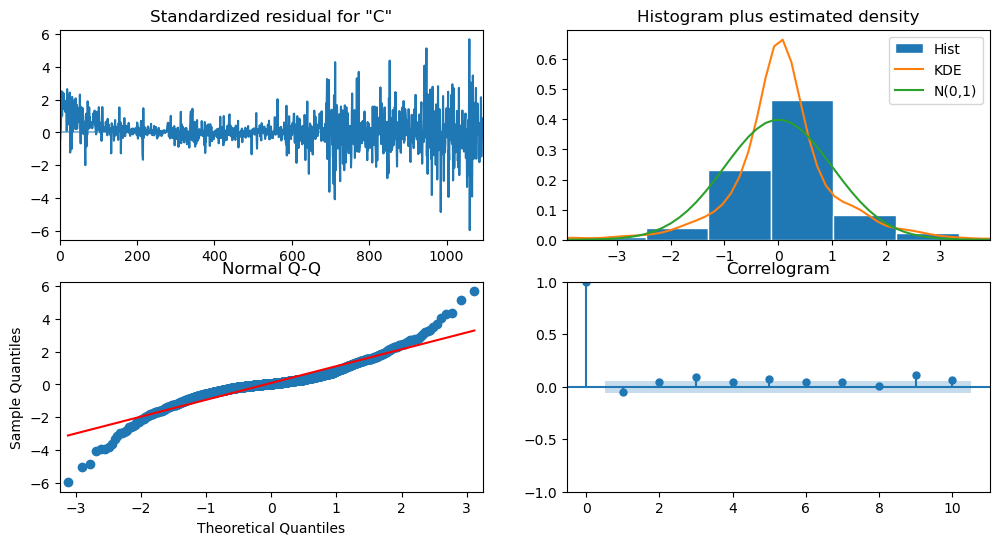

In [516]:
modelo_med_entrenado.plot_diagnostics(figsize=(12, 6))
plt.show()


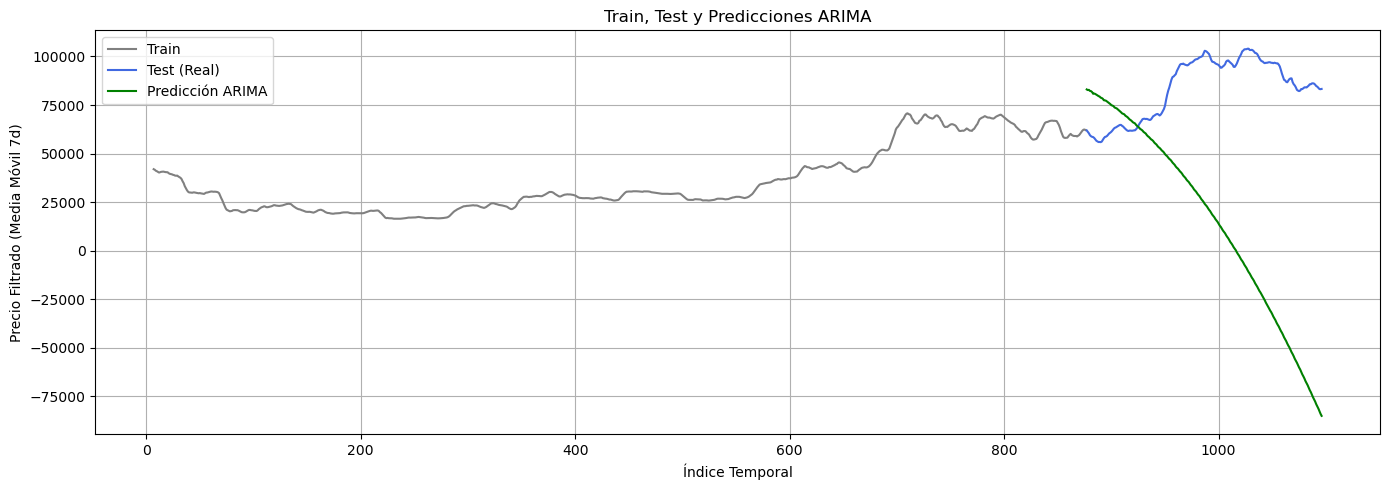

In [517]:
# 3. Hacer predicciones sobre el conjunto de prueba
forecast = modelo_med_entrenado.forecast(steps=len(test))

# 4. Crear el gráfico
plt.figure(figsize=(14, 5))
plt.plot(train.index, train, label='Train', color='gray')
plt.plot(test.index, test, label='Test (Real)', color='royalblue')
plt.plot(test.index, forecast, label='Predicción ARIMA', color='green')
plt.title('Train, Test y Predicciones ARIMA')
plt.xlabel('Índice Temporal')
plt.ylabel('Precio Filtrado (Media Móvil 7d)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Sarima

1. P	Estacional	Autoregresivo estacional (AR estacional)
2. D	Estacional	Diferencias estacionales
3. Q	Estacional	Promedios móviles estacionales (MA estacional)
4. s	Estacional	Periodo estacional (por ejemplo, 7 para datos diarios con patrón semanal)

In [518]:
serie_dif_estacional = df_btc['Close_7d'].diff(7)  # s=7 si semanal

In [519]:
from statsmodels.tsa.stattools import adfuller
prueba_adf(serie_dif_estacional.dropna())



--- Prueba ADF (Augmented Dickey-Fuller) para Serie ---
Estadístico ADF: -5.300973570147041
Valor p: 5.450283886269347e-06
Valores críticos:
   1%: -3.4365341571171166
   5%: -2.8642704999764907
   10%: -2.568223820754717

✅ Serie es estacionaria (rechazamos H0).


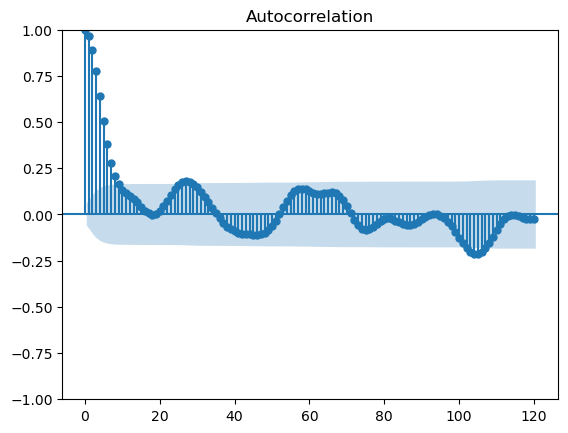

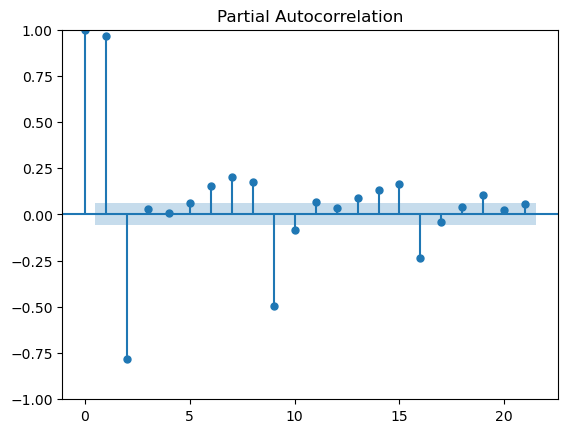

In [520]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(serie_dif_estacional.dropna(), lags=120)
plot_pacf(serie_dif_estacional.dropna(), lags=21)
plt.show()


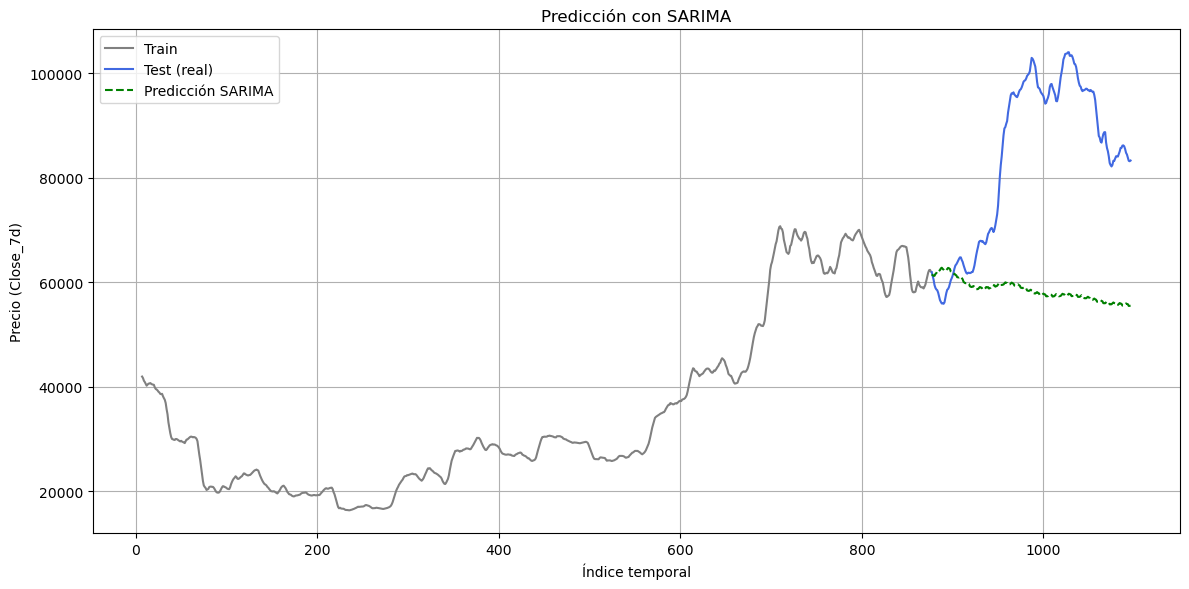

In [521]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Entrenar modelo SARIMA
modelo_sarima = SARIMAX(train, order=(4, 1, 2), seasonal_order=(2, 1, 0, 7))
modelo_sarima_fit = modelo_sarima.fit(disp=False)

# Pronóstico sobre el conjunto de test
forecast = modelo_sarima_fit.forecast(steps=len(test))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='gray')
plt.plot(test.index, test, label='Test (real)', color='royalblue')
plt.plot(test.index, forecast, label='Predicción SARIMA', color='green', linestyle='--')
plt.title('Predicción con SARIMA')
plt.xlabel('Índice temporal')
plt.ylabel('Precio (Close_7d)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [522]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 26021.54
RMSE: 30352.31


Dado que no se encuentra una tendencia previa se explorara otro modelo, devido a que nuestros datos son muy volatiles

## XGBoost

In [523]:
pip install xgboost

In [11]:
df_model=df_btc[['Date','Close']]
df_model = pd.merge(df_model, df_news_avg_score, how='left', left_on='Date', right_on='fecha')
df_model.fillna(0, inplace=True)
df_model.drop(columns=['fecha'], inplace=True)
df_model['Date'] = pd.to_datetime(df_model['Date'])


C:\Users\SANTI\AppData\Local\Temp\ipykernel_24220\628585364.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.



In [12]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1097 non-null   datetime64[ns]
 1   Close   1097 non-null   float64       
 2   score   1097 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB


### Modelo sin Noticias

In [13]:
pip install xgboost


     -------------------------------------- 150.0/150.0 MB 4.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


MAE: 2813.37
RMSE: 3565.21


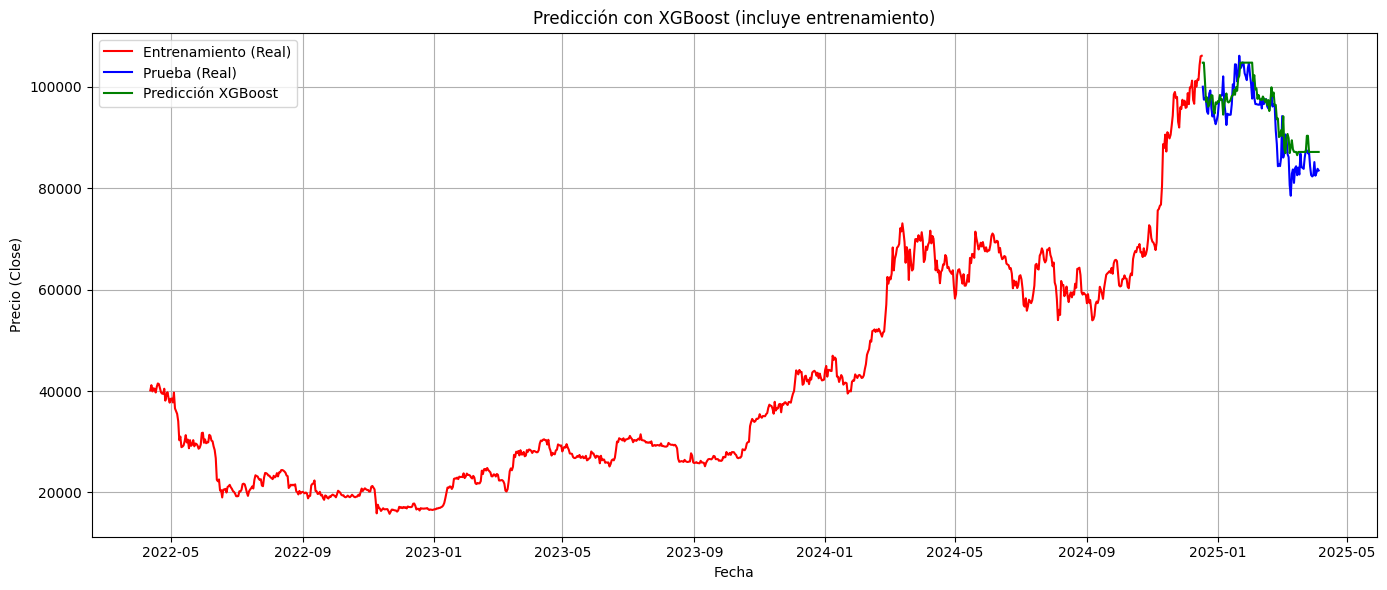

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Crear variables rezagadas (lags)
def crear_lags(data, target_col, n_lags):
    df = data.copy()
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df.dropna()

# --- Configuración ---
n_lags = 7

# 2. Crear dataset con lags
df_lags = crear_lags(df_model, 'Close', n_lags)

# 3. Separar en train/test
train_size = int(len(df_lags) * 0.90)
train = df_lags.iloc[:train_size]
test = df_lags.iloc[train_size:]

X_train = train.drop(columns=['Close', 'Date','score'])
y_train = train['Close']
X_test = test.drop(columns=['Close', 'Date','score'])
y_test = test['Close']

# 4. Entrenar modelo XGBoost
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)
model.fit(X_train, y_train)

# 5. Predicciones y métricas
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# 6. Visualización completa
plt.figure(figsize=(14, 6))

# Entrenamiento en rojo
plt.plot(df_model['Date'][y_train.index], y_train.values, label='Entrenamiento (Real)', color='red')

# Test real en azul
plt.plot(df_model['Date'][y_test.index], y_test.values, label='Prueba (Real)', color='blue')

# Predicción en verde
plt.plot(df_model['Date'][y_test.index], y_pred, label='Predicción XGBoost', color='green')

plt.title('Predicción con XGBoost (incluye entrenamiento)')
plt.xlabel('Fecha')
plt.ylabel('Precio (Close)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
df_model=df_model[1:]

MAE histórico: 401.97
RMSE histórico: 558.85


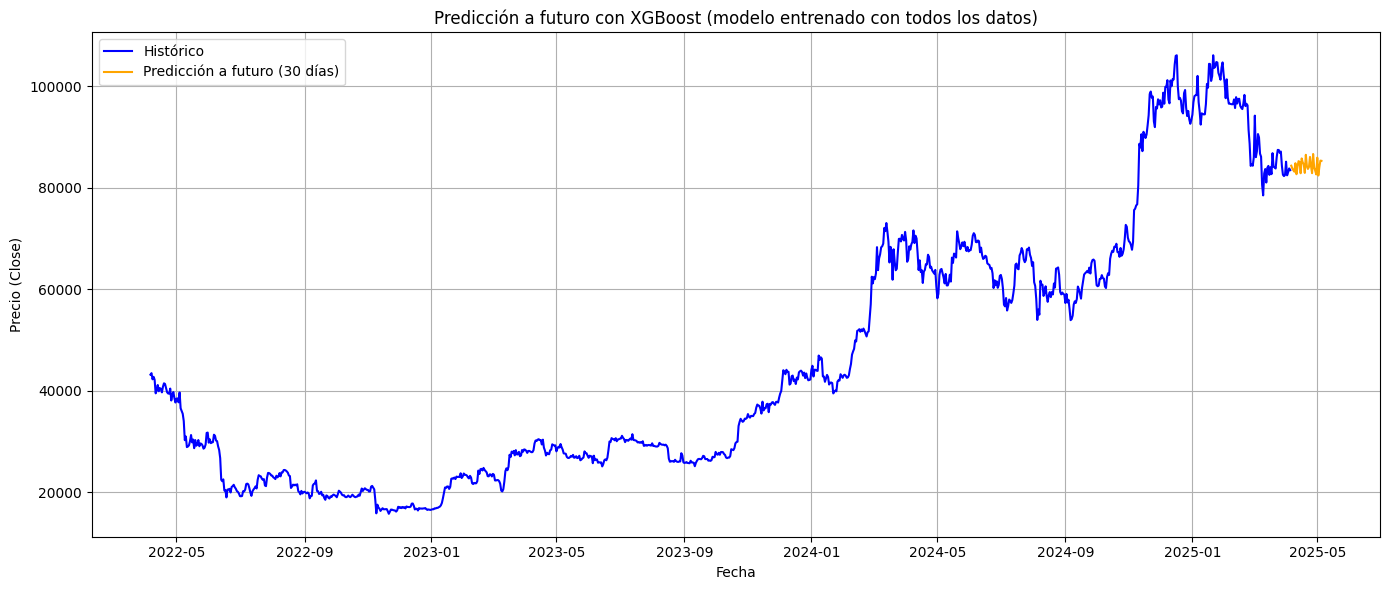

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Crear variables rezagadas (lags)
def crear_lags(data, target_col, n_lags):
    df = data.copy()
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df.dropna()

# 2. Configuración
n_lags = 7
n_forecasts = 30

# 3. Crear dataset con lags
df_lags = crear_lags(df_model, 'Close', n_lags)

# 4. Entrenamiento con TODOS los datos
X_all = df_lags.drop(columns=['Close', 'Date', 'score'])
y_all = df_lags['Close']

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)
model.fit(X_all, y_all)

# (Opcional) Métricas sobre el set completo (para evaluar desempeño histórico)
y_pred_hist = model.predict(X_all)
mae = mean_absolute_error(y_all, y_pred_hist)
rmse = np.sqrt(mean_squared_error(y_all, y_pred_hist))

print(f"MAE histórico: {mae:.2f}")
print(f"RMSE histórico: {rmse:.2f}")

# 5. Predicción recursiva a futuro
def forecast_future(model, X_last, n_forecast):
    current_input = X_last.values[-1].reshape(1, -1)
    forecasts = []
    for _ in range(n_forecast):
        pred = model.predict(current_input)[0]
        forecasts.append(pred)
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1] = pred
    return forecasts

future_preds = forecast_future(model, X_all, n_forecasts)

# 6. Crear fechas futuras desde la última fecha disponible
last_date = pd.to_datetime(df_model['Date'].max())
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecasts, freq='D')

# 7. Visualización
plt.figure(figsize=(14, 6))

# Datos históricos
plt.plot(pd.to_datetime(df_model['Date']), df_model['Close'], label='Histórico', color='blue')

# Predicción futura
plt.plot(future_dates, future_preds, label='Predicción a futuro (30 días)', color='orange')

plt.title('Predicción a futuro con XGBoost (modelo entrenado con todos los datos)')
plt.xlabel('Fecha')
plt.ylabel('Precio (Close)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Modelo Con Noticias 

MAE: 2610.62
RMSE: 3447.65


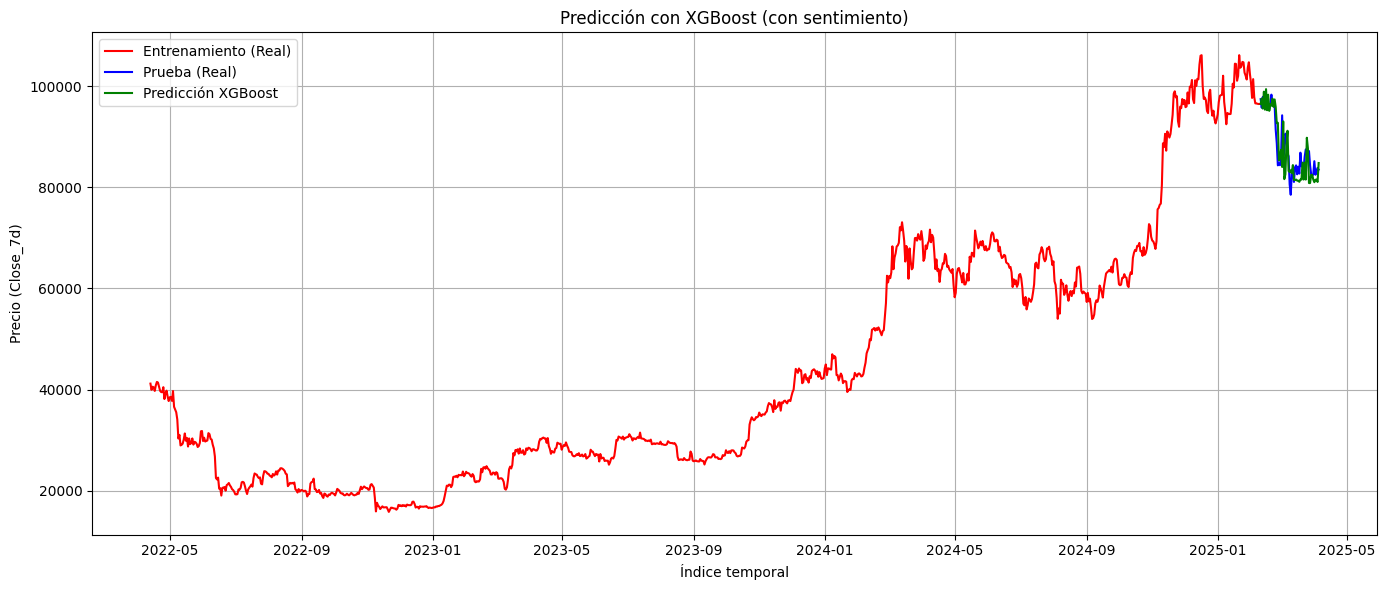

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Crear variables rezagadas (lags)
def crear_lags(data, target_col, n_lags):
    df = data.copy()
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df.dropna()

# Supón que tienes un DataFrame llamado df con una columna 'Close_7d'
# Reemplaza esto si tu DataFrame se llama distinto
n_lags = 7
df_lags = crear_lags(df_model, 'Close', n_lags)
# 2. Separar en conjunto de entrenamiento y prueba (80/20)
train_size = int(len(df_lags) * 0.95)
train = df_lags.iloc[:train_size]
test = df_lags.iloc[train_size:]

X_train = train.drop(columns=['Close', 'Date'])
y_train = train['Close']
X_test = test.drop(columns=['Close', 'Date'])
y_test = test['Close']

# 3. Entrenar el modelo XGBoost
model_sent = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

model_sent.fit(X_train, y_train)

# 4. Predicciones
y_pred = model_sent.predict(X_test)

# 5. Evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(14, 6))

# Graficar entrenamiento en rojo
plt.plot(df_btc['Date'][y_train.index], y_train.values, label='Entrenamiento (Real)', color='red')

# Graficar prueba real en azul
plt.plot(df_btc['Date'][y_test.index], y_test.values, label='Prueba (Real)', color='blue')

# Graficar predicción en verde punteado
plt.plot(df_btc['Date'][y_test.index], y_pred, label='Predicción XGBoost', color='green')

# Estética
plt.title('Predicción con XGBoost (con sentimiento)')
plt.xlabel('Índice temporal')
plt.ylabel('Precio (Close_7d)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




MAE (datos históricos): 389.28121951044534
RMSE (datos históricos): 544.7197975942689


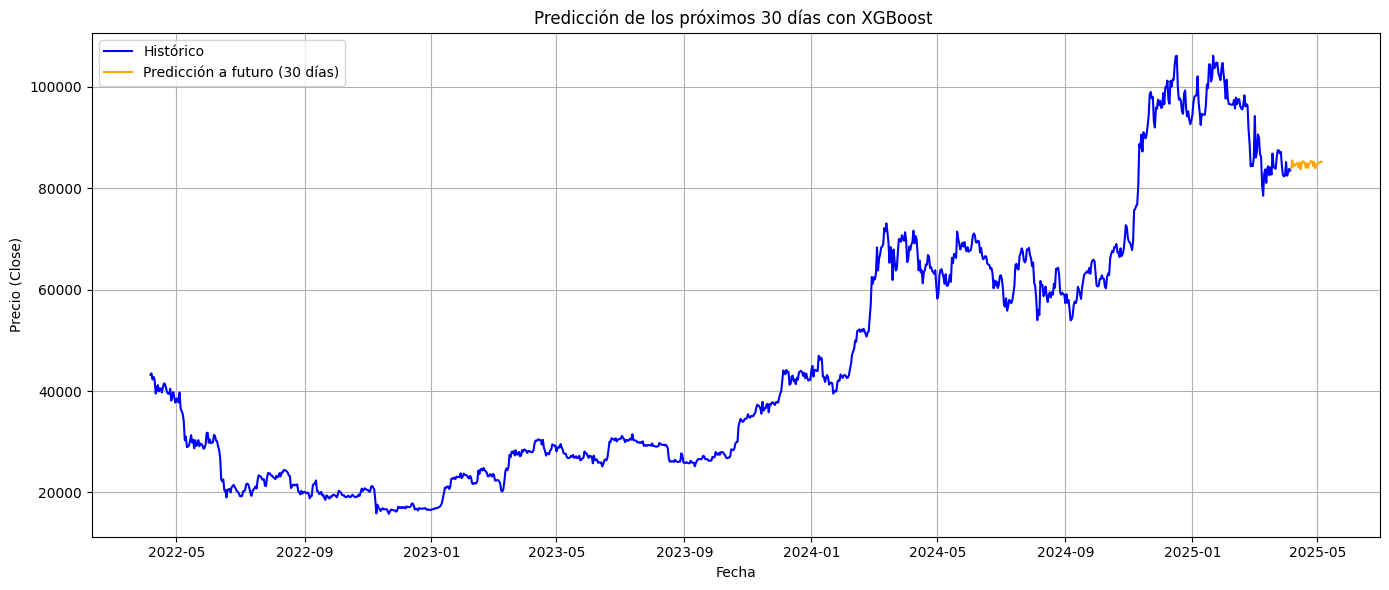

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Función para crear variables rezagadas (lags)
def crear_lags(data, target_col, n_lags):
    df = data.copy()
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df.dropna()

# Configuración: número de lags a usar
n_lags = 7

# 2. Crear dataset de entrenamiento a partir de df_model
df_lags = crear_lags(df_model, 'Close', n_lags)
# Se asume que df_model también tiene la columna 'Date'

# Aquí usamos todos los datos disponibles para el entrenamiento
X_all = df_lags.drop(columns=['Close', 'Date'])
y_all = df_lags['Close']

# 3. Entrenar el modelo XGBoost con todos los datos
model_sent = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

model_sent.fit(X_all, y_all)

# (Opcional) Si deseas evaluar en datos históricos, puedes predecir sobre X_all
y_pred_all = model_sent.predict(X_all)
print("MAE (datos históricos):", mean_absolute_error(y_all, y_pred_all))
print("RMSE (datos históricos):", np.sqrt(mean_squared_error(y_all, y_pred_all)))


# 4. Función para predecir futuros de forma recursiva
def forecast_future(model, X_last, n_forecast):
    """
    model: modelo entrenado
    X_last: DataFrame con los features (lags) utilizado para entrenar;
            se usa la última fila para iniciar la predicción recursiva.
    n_forecast: número de pasos a predecir (p.ej. 30 días)
    """
    # Tomamos la última fila como base para la predicción
    current_input = X_last.values[-1].reshape(1, -1)
    forecasts = []
    for _ in range(n_forecast):
        # Predecir el siguiente valor
        pred = model.predict(current_input)[0]
        forecasts.append(pred)
        # Actualizamos los lags: desplazamos a la izquierda (roll) y ponemos la predicción al final
        new_input = np.roll(current_input, shift=-1, axis=1)
        new_input[0, -1] = pred
        current_input = new_input
    return forecasts

# Predecir los próximos 30 días
n_forecasts = 30
future_preds = forecast_future(model_sent, X_all, n_forecasts)

# 5. Preparar la serie de fechas futuras a partir de la última fecha de df_model
ultima_fecha = pd.to_datetime(df_model['Date'].max())
future_dates = pd.date_range(start=ultima_fecha + pd.Timedelta(days=1), periods=n_forecasts, freq='D')

# 6. Visualización
plt.figure(figsize=(14, 6))

# Graficar datos históricos completos
plt.plot(pd.to_datetime(df_model['Date']), df_model['Close'], label='Histórico', color='blue')

# Graficar las predicciones futuras
plt.plot(future_dates, future_preds, label='Predicción a futuro (30 días)', color='orange')

plt.title('Predicción de los próximos 30 días con XGBoost ')
plt.xlabel('Fecha')
plt.ylabel('Precio (Close)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2025-04-06  78214.484375  83704.718750  77097.742188  83504.507812   
2025-04-07  79235.335938  81119.062500  74436.679688  78221.335938   
2025-04-08  76271.953125  80823.890625  76198.023438  79218.476562   
2025-04-09  82573.953125  83541.000000  74589.671875  76273.562500   
2025-04-10  79626.140625  82700.929688  78456.132812  82565.976562   

Price            Volume  
Ticker          BTC-USD  
Date                     
2025-04-06  36294853736  
2025-04-07  91262424987  
2025-04-08  48314590749  
2025-04-09  84213627038  
2025-04-10  44718000633  


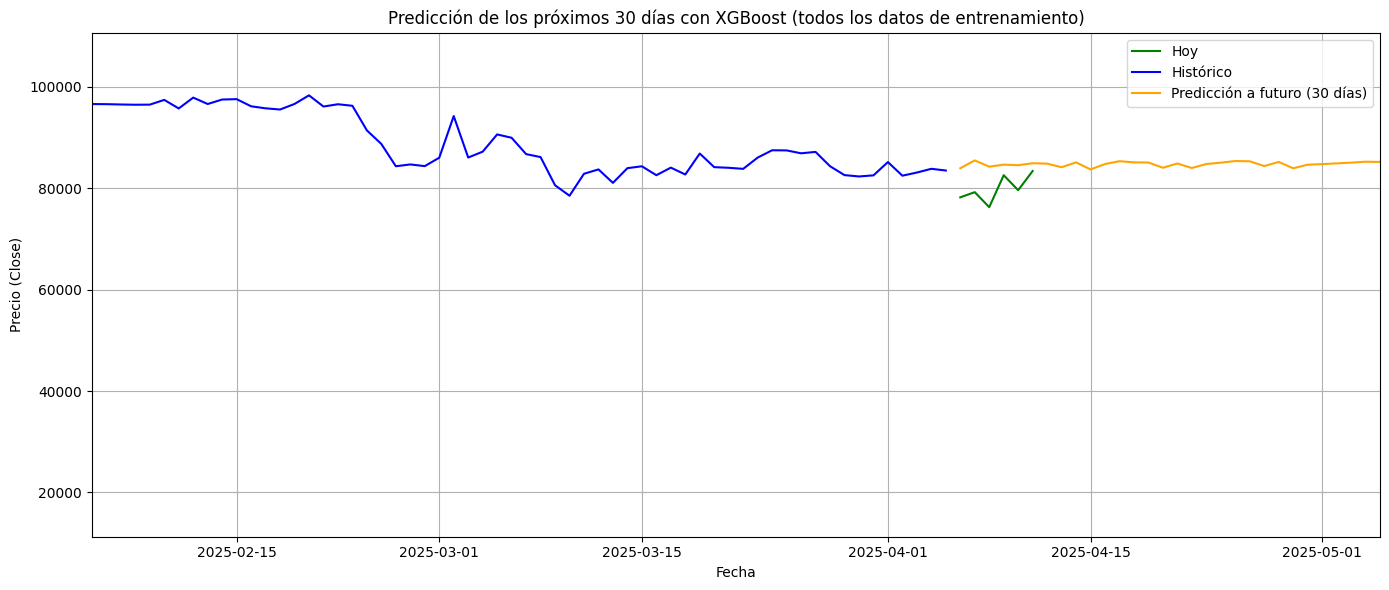

In [21]:

# Muestrame solo los ultimos 2 meses con la grafica anterior con la prediccion

plt.figure(figsize=(14, 6))
# Importar Datos historicos desde train hasta hoy con y finance
import yfinance as yf
#Fecha de hoy
today = pd.to_datetime("today").strftime("%Y-%m-%d")
df_model_t = yf.download("BTC-USD", start="2025-04-06", end=today)
print(df_model_t.head())

# Importar los datos de hoy
df_model_t = df_model_t.reset_index()
df_model_t['Date'] = pd.to_datetime(df_model_t['Date'])
#Graficar datos de hoy
plt.plot(pd.to_datetime(df_model_t['Date']), df_model_t['Close'], label='Hoy', color='green')
# Graficar datos históricos completos
plt.plot(pd.to_datetime(df_model['Date']), df_model['Close'], label='Histórico', color='blue')
# Graficar las predicciones futuras
plt.plot(future_dates, future_preds, label='Predicción a futuro (30 días)', color='orange')
plt.xlim(pd.to_datetime(df_model['Date']).max() - pd.DateOffset(months=2), pd.to_datetime(df_model['Date']).max() + pd.DateOffset(days=30))
plt.title('Predicción de los próximos 30 días con XGBoost (todos los datos de entrenamiento)')
plt.xlabel('Fecha')
plt.ylabel('Precio (Close)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Exportacion de las predicciones del Modelo

In [30]:
df_model

,Date,Close,score
1,2022-04-06,43206.738281,0.000000
2,2022-04-07,43503.847656,0.000000
3,2022-04-08,42287.664062,0.000000
4,2022-04-09,42782.136719,0.000000
5,2022-04-10,42207.671875,0.000000
...,...,...,...
1092,2025-04-01,85169.171875,-0.084074
1093,2025-04-02,82485.710938,-0.226506
1094,2025-04-03,83102.828125,0.000000
1095,2025-04-04,83843.804688,-0.313637


In [35]:
inicial.head()

,Date,Close,score,Fecha,Predicción
0,2022-04-06,NaN,0.0,NaT,NaN
1,2022-04-07,NaN,0.0,NaT,NaN
2,2022-04-08,NaN,0.0,NaT,NaN
3,2022-04-09,NaN,0.0,NaT,NaN
4,2022-04-10,NaN,0.0,NaT,NaN


# Cambio Diario

In [53]:
# Obtener el último valor real del cierre
ultimo_real = df_model[['Date', 'Close']].dropna().iloc[-1:]

# Preparar las predicciones futuras
preds = df_future_preds[['Fecha', 'Predicción']].copy()
preds.rename(columns={'Fecha': 'Date', 'Predicción': 'Close'}, inplace=True)
preds.reset_index(drop=True, inplace=True)

# Concatenar el último valor real con las predicciones
serie_diaria = pd.concat([ultimo_real, preds], ignore_index=True)

# Calcular el cambio porcentual diario
serie_diaria['Cambio_1d'] = serie_diaria['Close'].pct_change(periods=1) * 100

# Asignar solo los cambios de las predicciones (omitimos el real)
df_future_preds['Cambio_1d'] = serie_diaria.iloc[1:]['Cambio_1d'].reset_index(drop=True)

# Mostrar las primeras filas
df_future_preds.head(10)


,Fecha,Predicción,Cambio_7d,Cambio_1d
0,2025-04-06,83955.671875,1.968978,0.539939
1,2025-04-07,85497.273438,3.571651,1.836209
2,2025-04-08,84268.820312,-1.057133,-1.436833
3,2025-04-09,84663.804688,2.640571,0.468719
4,2025-04-10,84550.578125,1.742119,-0.133737
5,2025-04-11,84940.679688,1.308236,0.461382
6,2025-04-12,84860.078125,1.622998,-0.094892
7,2025-04-13,84153.632812,0.235796,-0.832483
8,2025-04-14,85112.992188,-0.449467,1.140009
9,2025-04-15,83721.773438,-0.649166,-1.634555


# Cambio Siguiente 7 dias

In [54]:
# Obtener los últimos 7 valores reales del histórico
ultimos_real = df_model[['Date', 'Close']].copy().dropna().iloc[-7:]

# Calcular el cambio porcentual de 7 días en las predicciones (a partir del día 8)
df_future_preds['Cambio_7d'] = df_future_preds['Predicción'].pct_change(periods=7) * 100

# Construir un dataframe combinado con los últimos valores reales y las primeras predicciones
primeros_preds = df_future_preds[['Fecha', 'Predicción']].iloc[:7].copy()
primeros_preds.rename(columns={'Fecha': 'Date', 'Predicción': 'Close'}, inplace=True)
concat_7 = pd.concat([ultimos_real, primeros_preds], ignore_index=True)

# Calcular el cambio porcentual de 7 días para los primeros valores predichos
concat_7['Cambio_7d'] = concat_7['Close'].pct_change(periods=7) * 100
cambios_iniciales = concat_7.iloc[7:][['Cambio_7d']].reset_index(drop=True)

# Asignar los valores calculados a las filas correspondientes del dataframe de predicciones
df_future_preds.loc[:6, 'Cambio_7d'] = cambios_iniciales['Cambio_7d']
df_future_preds.head(10)



C:\Users\SANTI\AppData\Local\Temp\ipykernel_24220\1122602833.py:17: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.96897774  3.57165132 -1.05713317  2.64057099  1.74211881  1.30823619
  1.62299808]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.



,Fecha,Predicción,Cambio_7d,Cambio_1d
0,2025-04-06,83955.671875,1.968978,0.539939
1,2025-04-07,85497.273438,3.571651,1.836209
2,2025-04-08,84268.820312,-1.057133,-1.436833
3,2025-04-09,84663.804688,2.640571,0.468719
4,2025-04-10,84550.578125,1.742119,-0.133737
5,2025-04-11,84940.679688,1.308236,0.461382
6,2025-04-12,84860.078125,1.622998,-0.094892
7,2025-04-13,84153.632812,0.235796,-0.832483
8,2025-04-14,85112.992188,-0.449467,1.140009
9,2025-04-15,83721.773438,-0.649166,-1.634555


# Exportar el Dataset

In [56]:
df_future_preds.to_csv("../Datos/predicciones_XGBoost.csv", index=False)